# **reading the data**

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import tensorflow as tf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [2]:
#reading the data 
data=pd.read_csv('/content/Pinket_Task.csv')

In [3]:
#data information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36041 entries, 0 to 36040
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   item_id                   36041 non-null  int64  
 1   checkout_date             36041 non-null  object 
 2   checkout_date_item_count  33238 non-null  float64
 3   shop_date                 35363 non-null  object 
 4   shop_date_item_count      28936 non-null  float64
 5   item_price                24588 non-null  float64
 6   item_category             36015 non-null  float64
 7   shop_status               36041 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 2.2+ MB


In [4]:
# datadrame heads 
data.keys()

Index(['item_id', 'checkout_date', 'checkout_date_item_count', 'shop_date',
       'shop_date_item_count', 'item_price', 'item_category', 'shop_status'],
      dtype='object')

In [5]:
data.isna().sum()

item_id                         0
checkout_date                   0
checkout_date_item_count     2803
shop_date                     678
shop_date_item_count         7105
item_price                  11453
item_category                  26
shop_status                     0
dtype: int64

In [6]:
sum(data.checkout_date_item_count<0)

7468

In [7]:
sum(data.shop_date_item_count<0)

9983

# **cleaning data**

In [8]:
#drop missing data of item_category
data.dropna(subset=['item_category'],inplace=True)

#replace each item product by mean of each category price 
data["item_price"] = data.groupby("item_category")['item_price'].transform(lambda x: x.fillna(x.mean()))

In [9]:
#change shope_date and checkout_date dtype ---> datetime
data.checkout_date=pd.to_datetime(data.checkout_date)
data.shop_date=pd.to_datetime(data.shop_date)

#calculate the mean of time diffrence between shop data and checkout date 
mean_time=(data.dropna(subset=['shop_date']).shop_date-data.dropna(subset=['shop_date']).checkout_date).mean()

#replace shop_date null value first of all by 0 and after that replace zeros by value of checkout_date plus mean of mean_time 
data['shop_date'] = data['shop_date'].fillna(0)

for i in data.index:
    if data.shop_date[i]==0:
        data.shop_date[i]=data.checkout_date[i]+mean_time

data.shop_date=pd.to_datetime(data.shop_date)

#build a column error for how much it takes that some one make an order till shop it by shopers 
data['error']=data.shop_date-data.checkout_date

#turn error to minutes
data['delta']=0
for j in data.index:
    data['delta'][j]=pd.Timedelta(data.error[j]).seconds / 60.0

In [10]:
#skip the useless column
#data=data[['checkout_date_item_count','delta','shop_date_item_count', 'item_price', 'item_category', 'shop_status']]

In [ ]:
# change shop status type to int 
data.shop_status[data.shop_status=='FOUND']=1
data.shop_status[data.shop_status=='NOT_FOUND']=0
data.shop_status[data.shop_status=='CANCELED']=0
data.shop_status=pd.to_numeric(data.shop_status)

In [ ]:
for k in data.index:
    if data['checkout_date_item_count'][k]==-1:
        data['checkout_date_item_count'][k]=np.nan

In [13]:
for l in data.index:
    if data['shop_date_item_count'][l]==-1:
        data['shop_date_item_count'][l]=np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
data["checkout_date_item_count"] = data.groupby("item_category")["checkout_date_item_count"].transform(lambda x: x.fillna(x.median()))

In [15]:
data["shop_date_item_count"] = data.groupby("item_category")["shop_date_item_count"].transform(lambda x: x.fillna(x.median()))

In [16]:
#data null value 
data.isna().sum()

item_id                       0
checkout_date                 0
checkout_date_item_count     37
shop_date                     0
shop_date_item_count         38
item_price                  890
item_category                 0
shop_status                   0
error                         0
delta                         0
dtype: int64

In [17]:
data=data.dropna()

In [19]:
data['day_shop']=0
min_date=min(data['shop_date'])
for i in data.index:
    data['day_shop'][i]=pd.Timedelta(data['shop_date'][i]-min_date).days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
data.describe()

,item_id,checkout_date_item_count,shop_date_item_count,item_price,item_category,shop_status,error,delta,day_shop
count,3.512500e+04,35125.000000,35125.000000,35125.000000,35125.000000,35125.000000,35125,35125.000000,35125.000000
mean,9.915697e+05,521.424641,467.355103,13718.302226,81.015004,0.925979,0 days 15:49:31.447867700,669.837637,27.703915
std,8.117879e+05,1280.956720,1100.449638,14867.084456,48.438892,0.261809,0 days 13:34:04.041954563,455.930170,16.265946
min,4.385500e+05,-2.000000,0.000000,500.000000,2.000000,0.000000,0 days 00:06:23.157000,0.000000,0.000000
25%,4.617730e+05,82.000000,91.500000,5000.000000,48.000000,1.000000,0 days 04:16:13.666000,175.000000,14.000000
50%,4.916590e+05,164.000000,167.500000,10470.000000,70.000000,1.000000,0 days 15:17:41.611000,754.000000,27.000000
75%,1.566334e+06,399.500000,366.000000,17000.000000,131.000000,1.000000,0 days 21:17:34.502000,1063.000000,41.000000
max,3.756670e+06,36967.000000,36654.000000,299200.000000,186.000000,1.000000,5 days 00:37:25.539000,1439.000000,62.000000


In [28]:
data.checkout_date_item_count=abs(data.checkout_date_item_count)
data.checkout_date_item_count=abs(data.checkout_date_item_count)

In [29]:
data['differ'] = data.apply(lambda row: row.checkout_date_item_count - row.shop_date_item_count, axis=1)
data.differ=np.sign(data.differ)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35125 entries, 0 to 36040
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   item_id                   35125 non-null  int64          
 1   checkout_date             35125 non-null  datetime64[ns] 
 2   checkout_date_item_count  35125 non-null  float64        
 3   shop_date                 35125 non-null  datetime64[ns] 
 4   shop_date_item_count      35125 non-null  float64        
 5   item_price                35125 non-null  float64        
 6   item_category             35125 non-null  float64        
 7   shop_status               35125 non-null  int64          
 8   error                     35125 non-null  timedelta64[ns]
 9   delta                     35125 non-null  int64          
 10  day_shop                  35125 non-null  int64          
 11  differ                    35125 non-null  float64        
dtypes: d

# **explore the data task1-a**

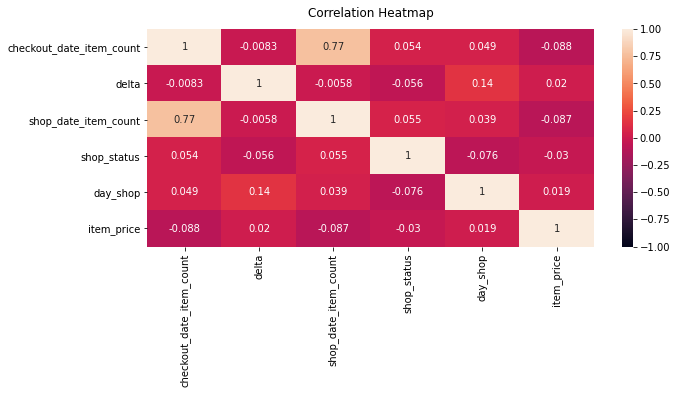

In [34]:
# Increase the size of the heatmap.
plt.figure(figsize=(10,4))

heatmap = sns.heatmap(data[['checkout_date_item_count', 'delta', 'shop_date_item_count','shop_status','day_shop',
       'item_price']].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

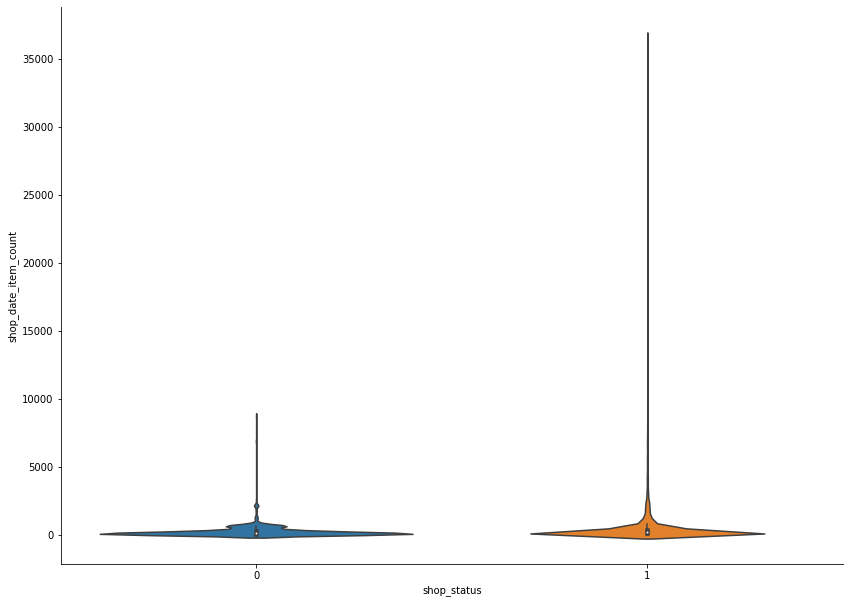

In [35]:
# violin plot to show relationship between 2 categorical variable 
sns.catplot(x="shop_status", y="shop_date_item_count",kind="violin", split=True, data=data,height=8.27, aspect=11.7/8.27)

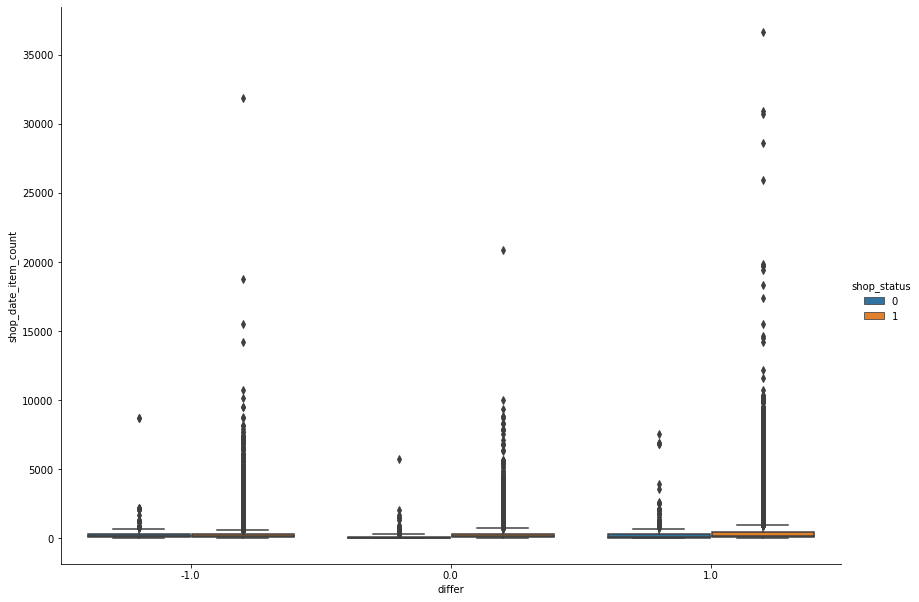

In [36]:
sns.catplot(x="differ", y="shop_date_item_count", hue="shop_status", kind="box", data=data,height=8.27, aspect=11.7/8.27)

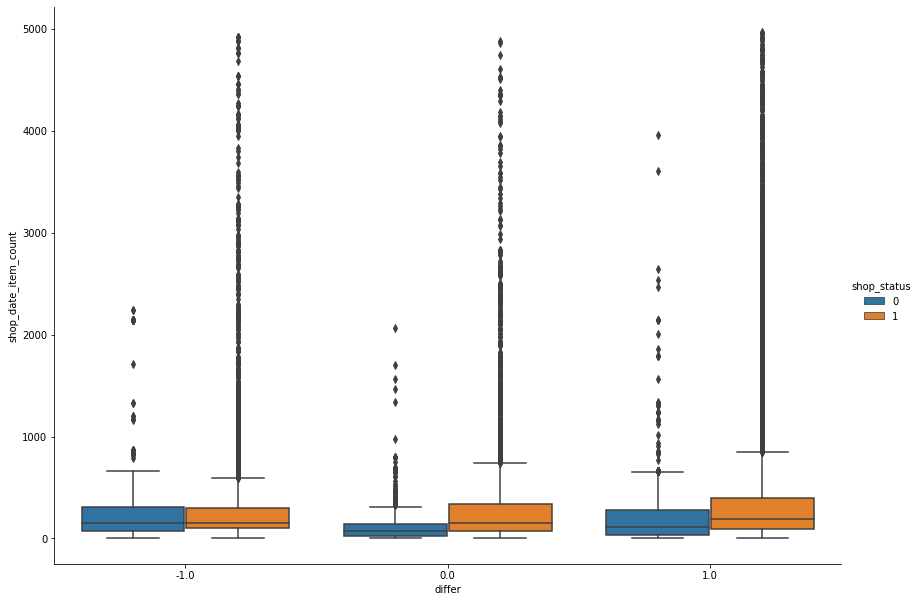

In [37]:
sns.catplot(x="differ", y="shop_date_item_count", hue="shop_status", kind="box", data=data[data.shop_date_item_count<5000],height=8.27, aspect=11.7/8.27)

In [38]:
data[data.shop_date_item_count>7000]

,item_id,checkout_date,checkout_date_item_count,shop_date,shop_date_item_count,item_price,item_category,shop_status,error,delta,day_shop,differ
13,2182555,2021-02-01 20:33:59.125,9188.0,2021-02-02 12:37:56.842,9099.0,20551.219512,58.0,1,0 days 16:03:57.717000,963,1,1.0
24,490003,2021-03-11 18:14:37.385,7797.0,2021-03-12 14:42:16.038,7671.0,14500.000000,9.0,1,0 days 20:27:38.653000,1227,39,1.0
141,2182555,2021-02-01 17:05:59.641,9270.0,2021-02-02 10:43:54.913,9154.0,20551.219512,58.0,1,0 days 17:37:55.272000,1057,1,1.0
231,2182555,2021-02-01 21:58:00.370,9188.0,2021-02-02 14:30:23.636,9099.0,20551.219512,58.0,1,0 days 16:32:23.266000,992,1,1.0
249,442651,2021-03-07 02:39:01.197,857.5,2021-03-08 10:53:36.315,10180.0,17500.000000,130.0,1,1 days 08:14:35.118000,494,35,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35131,493225,2021-03-11 16:42:03.979,26.0,2021-03-12 15:47:56.840,7137.0,13200.000000,69.0,1,0 days 23:05:52.861000,1385,39,-1.0
35139,442651,2021-03-06 21:14:19.666,10270.0,2021-03-08 11:00:30.340,10180.0,17500.000000,130.0,1,1 days 13:46:10.674000,826,35,1.0
35639,463984,2021-02-20 11:17:23.759,2007.0,2021-02-20 15:03:17.404,8797.0,2300.000000,70.0,1,0 days 03:45:53.645000,225,19,-1.0
35777,442651,2021-03-06 22:22:41.785,10270.0,2021-03-07 09:56:06.554,10265.0,17500.000000,130.0,1,0 days 11:33:24.769000,693,33,1.0


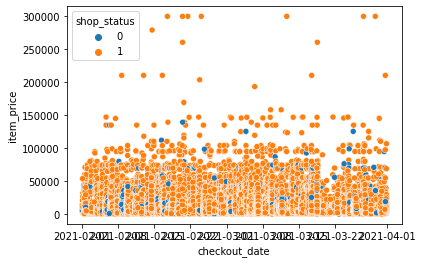

In [39]:
sns.scatterplot(x="checkout_date", y="item_price",hue='shop_status' ,data=data)

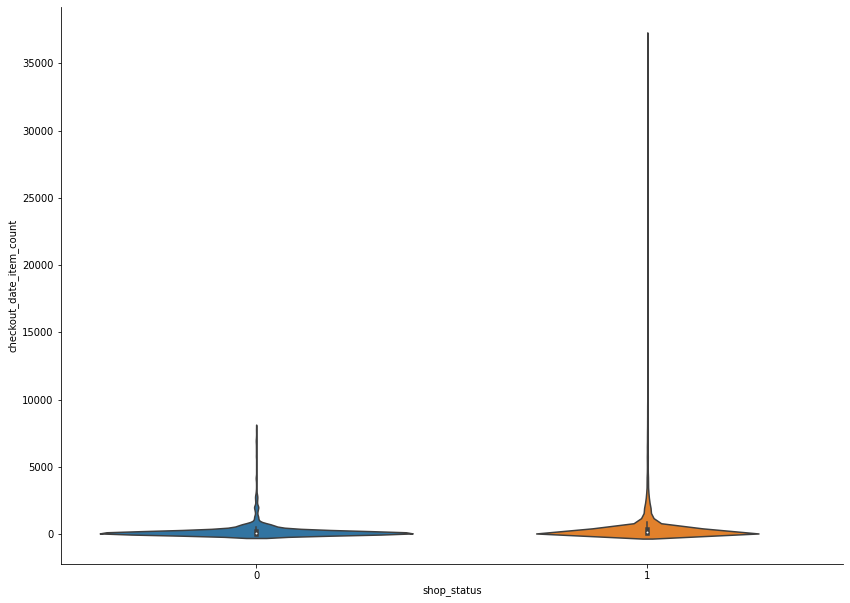

In [40]:
# violin plot to show relationship between 2 categorical variable 
sns.catplot(x="shop_status", y="checkout_date_item_count",kind="violin", split=True, data=data,height=8.27, aspect=11.7/8.27)

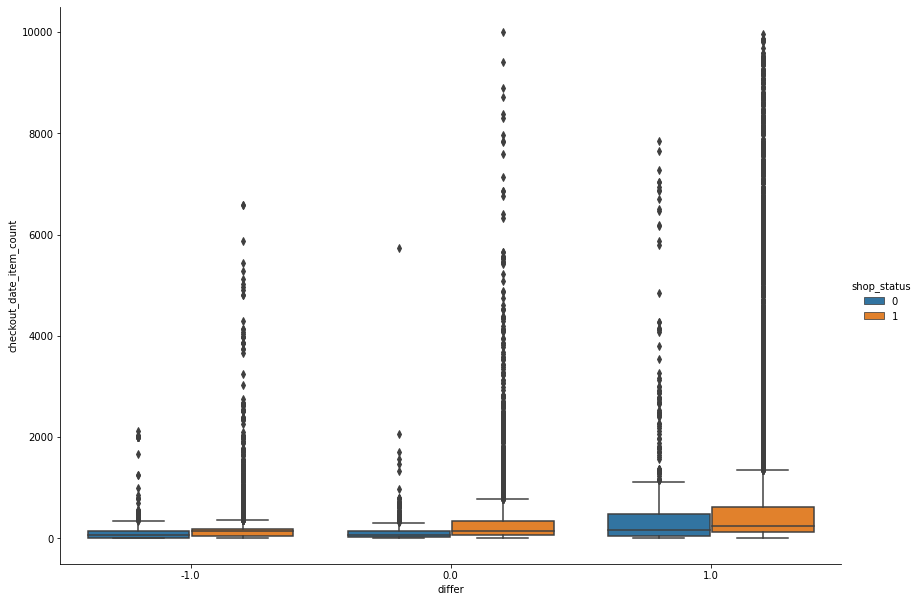

In [41]:
sns.catplot(x="differ", y="checkout_date_item_count", hue="shop_status", kind="box", data=data[data.checkout_date_item_count<10000],height=8.27, aspect=11.7/8.27)

In [42]:
data[data.checkout_date_item_count>8000]

,item_id,checkout_date,checkout_date_item_count,shop_date,shop_date_item_count,item_price,item_category,shop_status,error,delta,day_shop,differ
13,2182555,2021-02-01 20:33:59.125,9188.0,2021-02-02 12:37:56.842,9099.0,20551.219512,58.0,1,0 days 16:03:57.717000,963,1,1.0
141,2182555,2021-02-01 17:05:59.641,9270.0,2021-02-02 10:43:54.913,9154.0,20551.219512,58.0,1,0 days 17:37:55.272000,1057,1,1.0
231,2182555,2021-02-01 21:58:00.370,9188.0,2021-02-02 14:30:23.636,9099.0,20551.219512,58.0,1,0 days 16:32:23.266000,992,1,1.0
344,2182555,2021-02-01 09:33:36.308,9393.0,2021-02-01 13:24:34.546,9350.0,20551.219512,58.0,1,0 days 03:50:58.238000,230,0,1.0
381,451852,2021-02-01 03:26:28.400,10382.0,2021-02-01 11:43:34.646,873.0,17900.000000,130.0,1,0 days 08:17:06.246000,497,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
34809,442651,2021-03-06 20:48:42.742,10270.0,2021-03-07 09:29:25.189,873.0,17500.000000,130.0,1,0 days 12:40:42.447000,760,33,1.0
35120,451852,2021-03-06 20:48:42.742,9509.0,2021-03-07 09:29:25.189,873.0,17900.000000,130.0,1,0 days 12:40:42.447000,760,33,1.0
35139,442651,2021-03-06 21:14:19.666,10270.0,2021-03-08 11:00:30.340,10180.0,17500.000000,130.0,1,1 days 13:46:10.674000,826,35,1.0
35777,442651,2021-03-06 22:22:41.785,10270.0,2021-03-07 09:56:06.554,10265.0,17500.000000,130.0,1,0 days 11:33:24.769000,693,33,1.0


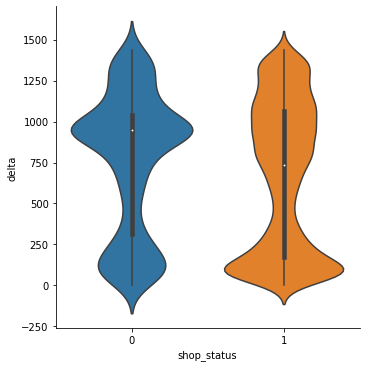

In [43]:
# violin plot to show relationship between 2 categorical variable 
sns.catplot(x="shop_status", y="delta",kind="violin", data=data)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count of shop at day


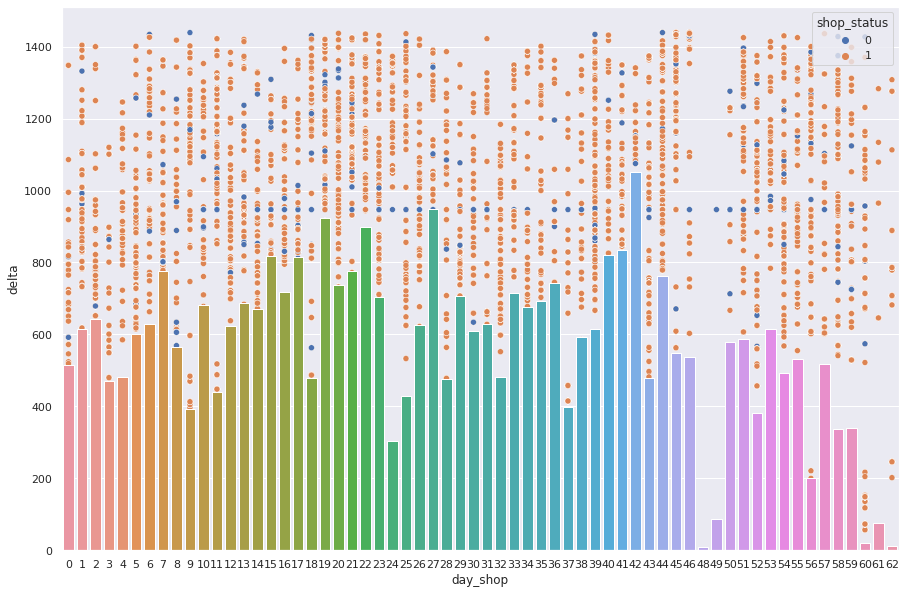

In [110]:
result = data.groupby(['day_shop']).size()
sns.scatterplot(data.day_shop,data.delta,hue=data.shop_status)
# plot the result
sns.barplot(x = result.index, y = result.values)

print('count of shop at day')

In [115]:
data[data.day_shop==60]

,item_id,checkout_date,checkout_date_item_count,shop_date,shop_date_item_count,item_price,item_category,shop_status,error,delta,day_shop,differ
19789,456940,2021-03-31 13:01:01.601,122.0,2021-04-03 10:24:49.149,155.5,15500.000000,34.0,1,2 days 21:23:47.548000,1283,60,-1.0
19790,1585489,2021-03-31 13:01:01.601,55.0,2021-04-03 10:24:49.149,74.0,2750.000000,51.0,1,2 days 21:23:47.548000,1283,60,-1.0
19791,442753,2021-03-31 13:01:01.601,104.0,2021-04-03 10:24:49.149,155.5,23200.000000,34.0,1,2 days 21:23:47.548000,1283,60,-1.0
19841,483772,2021-03-31 14:53:01.184,1543.0,2021-04-03 09:47:04.051,1498.0,1000.000000,133.0,1,2 days 18:54:02.867000,1134,60,1.0
19842,445084,2021-03-31 14:53:01.184,245.0,2021-04-03 09:47:04.051,237.0,6000.000000,132.0,1,2 days 18:54:02.867000,1134,60,1.0
19872,488809,2021-03-31 15:51:21.971,82.0,2021-04-03 09:51:04.664,82.0,21500.000000,95.0,0,2 days 17:59:42.693000,1079,60,0.0
20651,487801,2021-03-31 15:51:21.971,429.0,2021-04-03 09:51:04.664,414.0,4900.000000,10.0,1,2 days 17:59:42.693000,1079,60,1.0
20652,688363,2021-03-31 15:51:21.971,399.0,2021-04-03 09:51:04.664,385.0,6000.000000,110.0,1,2 days 17:59:42.693000,1079,60,1.0
21288,2397847,2021-03-31 23:01:03.944,88.0,2021-04-03 09:47:04.051,85.0,68919.166667,15.0,1,2 days 10:46:00.107000,646,60,1.0
21289,484933,2021-03-31 23:01:03.944,463.0,2021-04-03 09:47:04.051,453.0,106700.000000,46.0,1,2 days 10:46:00.107000,646,60,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


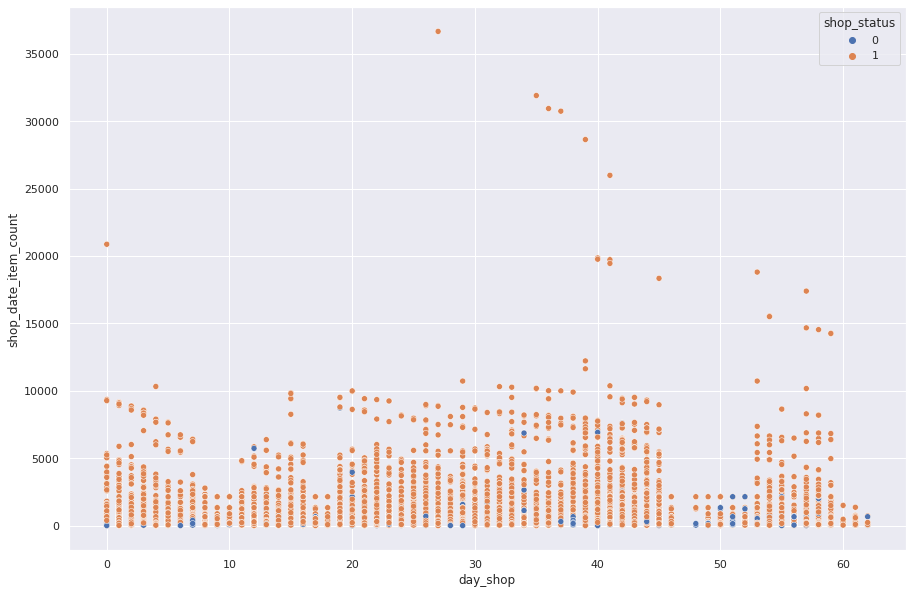

In [117]:
sns.scatterplot(data.day_shop,data.shop_date_item_count,hue=data.shop_status)

In [ ]:
data[data.day_shop==42]

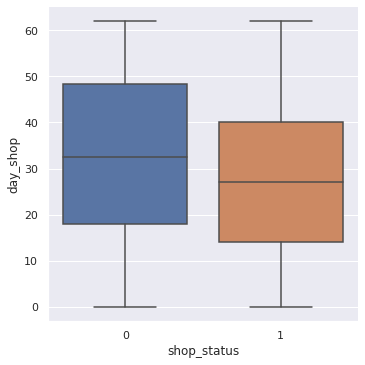

In [69]:
# violin plot to show relationship between 2 categorical variable 
sns.catplot(x="shop_status", y="day_shop",kind="box", data=data)

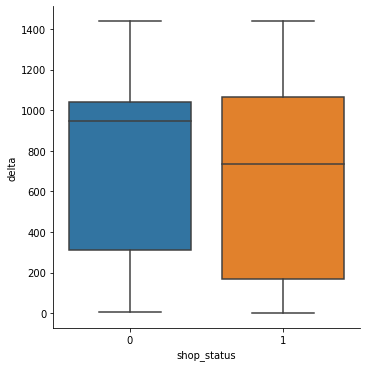

In [44]:
# violin plot to show relationship between 2 categorical variable 
sns.catplot(x="shop_status", y="delta",kind="box", data=data)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


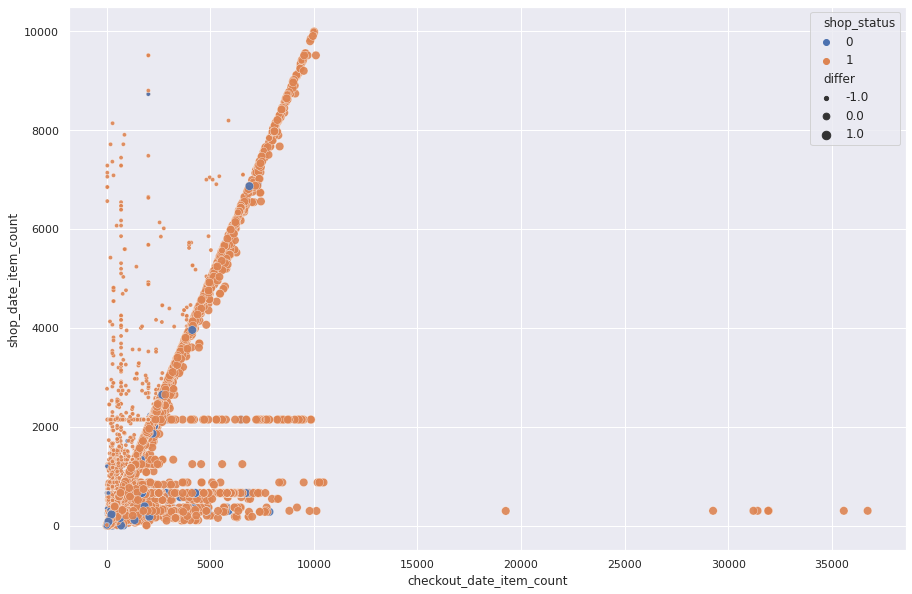

In [45]:
sns.set(rc={'figure.figsize':(15,10)})
sns.color_palette("husl", 9)
sns.scatterplot(data[data.shop_date_item_count<10000].checkout_date_item_count,
                data[data.shop_date_item_count<10000].shop_date_item_count,
                hue=data[data.shop_date_item_count<10000].shop_status,
                size=data[data.shop_date_item_count<10000].differ,
                alpha=0.9,size_order=[4,6,8])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


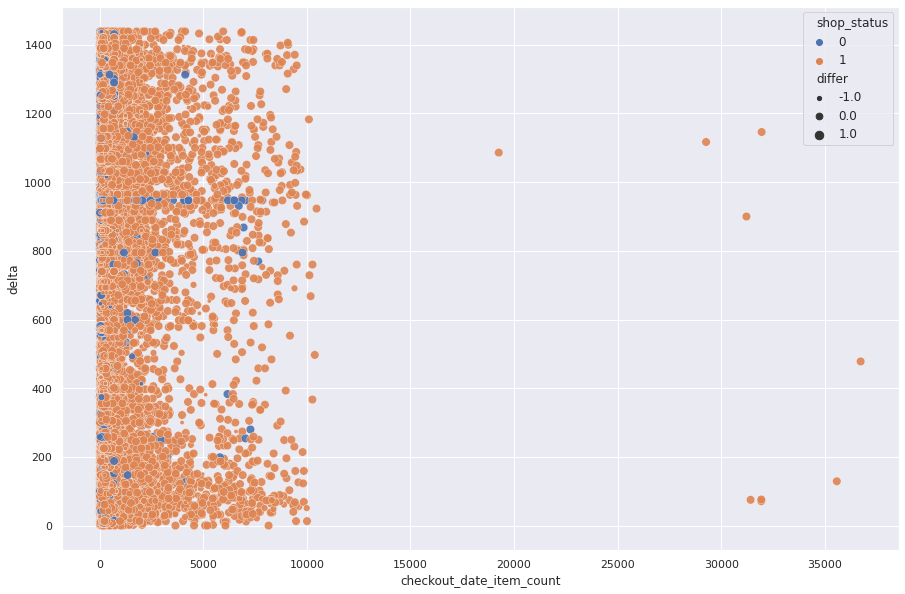

In [121]:
sns.scatterplot(data[data.shop_date_item_count<10000].checkout_date_item_count,
                data[data.shop_date_item_count<10000].delta,
                hue=data[data.shop_date_item_count<10000].shop_status,
                size=data[data.shop_date_item_count<10000].differ,
                alpha=0.9,size_order=[4,6,8])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


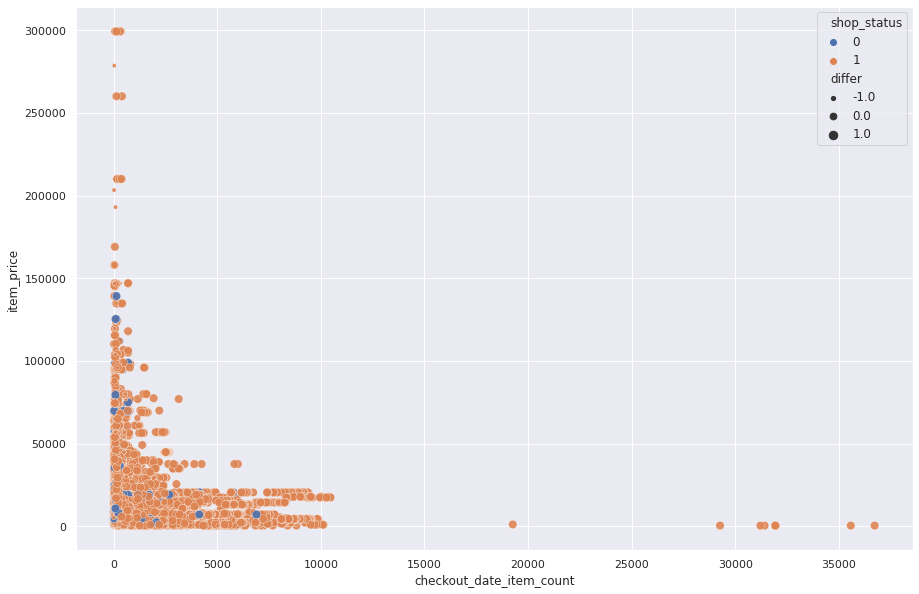

In [47]:
sns.scatterplot(data[data.shop_date_item_count<10000].checkout_date_item_count,
                data[data.shop_date_item_count<10000].item_price,
                hue=data[data.shop_date_item_count<10000].shop_status,
                size=data[data.shop_date_item_count<10000].differ,
                alpha=0.9,size_order=[4,6,8])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


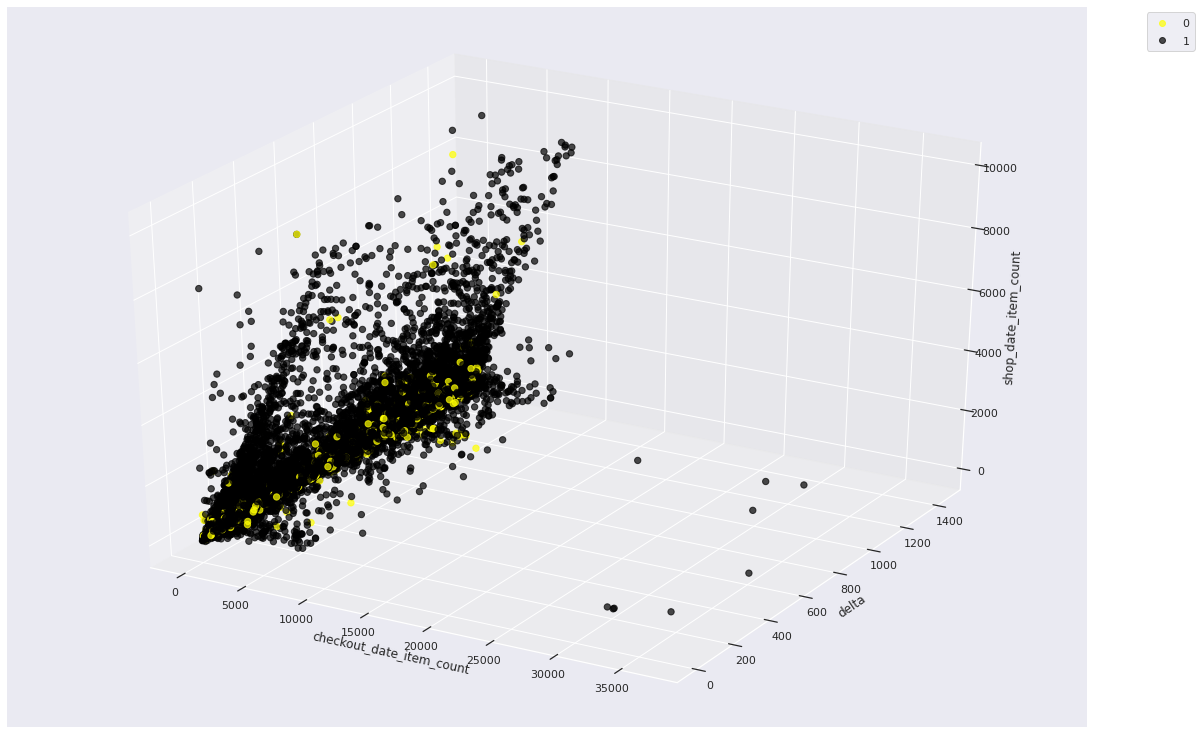

In [118]:
# axes instance
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(data[data.shop_date_item_count<10000].checkout_date_item_count,
                data[data.shop_date_item_count<10000].delta,
                data[data.shop_date_item_count<10000].shop_date_item_count,

                c=data[data.shop_date_item_count<10000].shop_status,  alpha=0.7,
                s=40,cmap='gnuplot_r')
ax.set_xlabel('checkout_date_item_count')
ax.set_ylabel('delta')
ax.set_zlabel('shop_date_item_count')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


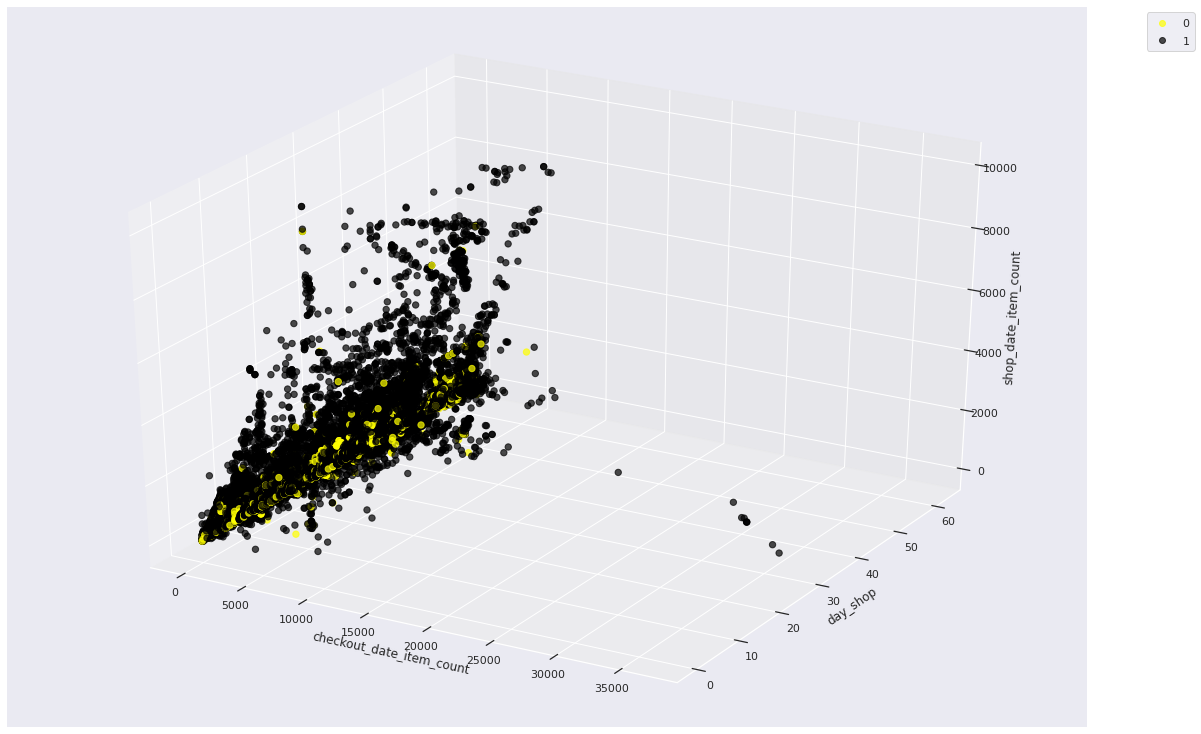

In [119]:
# axes instance
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(data[data.shop_date_item_count<10000].checkout_date_item_count,
                data[data.shop_date_item_count<10000].day_shop,
                data[data.shop_date_item_count<10000].shop_date_item_count,
                
                c=data[data.shop_date_item_count<10000].shop_status,  alpha=0.7,
                s=40,cmap='gnuplot_r')
ax.set_xlabel('checkout_date_item_count')
ax.set_ylabel('day_shop')
ax.set_zlabel('shop_date_item_count')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


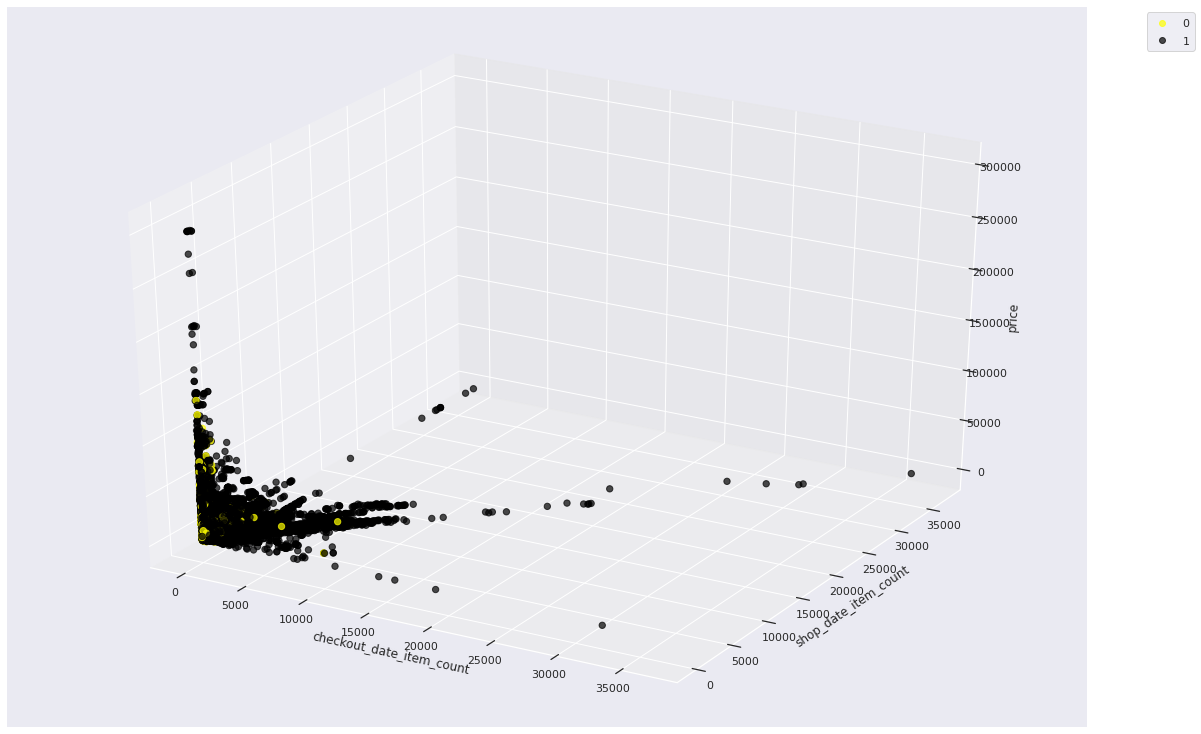

In [124]:
# axes instance
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(data.shop_date_item_count,
                data.checkout_date_item_count,
                data.item_price,

                

                c=data.shop_status,  alpha=0.7,
                s=40,cmap='gnuplot_r')
ax.set_xlabel('checkout_date_item_count')
ax.set_ylabel('shop_date_item_count')
ax.set_zlabel('price')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

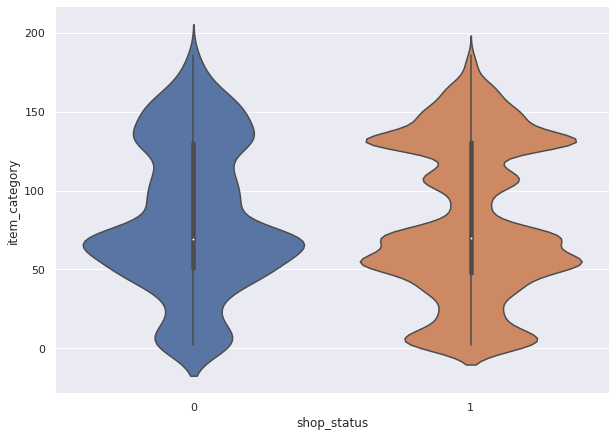

In [50]:
# violin plot to show relationship between 2 categorical variable 

sns.catplot(x="shop_status", y="item_category",kind="violin", split=True, data=data,height=6, aspect=11.7/8.27)

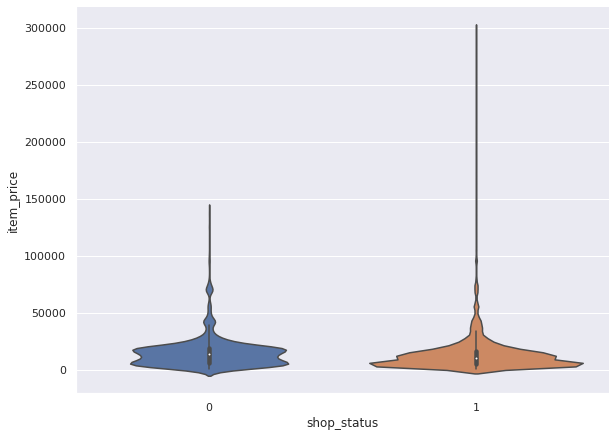

In [51]:
# violin plot to show relationship between 2 categorical variable 
sns.catplot(x="shop_status", y="item_price",kind="violin", split=True, data=data,height=6, aspect=11.7/8.27)

In [52]:
data[data.item_price>150000]

,item_id,checkout_date,checkout_date_item_count,shop_date,shop_date_item_count,item_price,item_category,shop_status,error,delta,day_shop,differ
569,799462,2021-03-18 13:36:06.650,395.0,2021-03-19 16:59:40.493,123.0,260000.0,60.0,1,1 days 03:23:33.843000,203,46,1.0
3735,737119,2021-03-06 10:29:32.886,88.0,2021-03-06 11:28:26.763,92.0,193000.0,15.0,1,0 days 00:58:53.877000,58,33,-1.0
6338,669979,2021-02-08 16:19:54.202,187.0,2021-02-09 13:14:35.439,53.5,210000.0,89.0,1,0 days 20:54:41.237000,1254,8,1.0
7121,492403,2021-03-11 13:24:46.523,34.0,2021-03-12 11:59:34.776,33.0,158000.0,69.0,1,0 days 22:34:48.253000,1354,39,1.0
7397,495607,2021-03-12 15:26:51.196,341.0,2021-03-13 15:19:32.910,123.0,299200.0,60.0,1,0 days 23:52:41.714000,1432,40,1.0
12175,669979,2021-02-12 22:00:59.372,53.0,2021-02-13 10:54:19.002,53.5,210000.0,89.0,1,0 days 12:53:19.630000,773,12,-1.0
12842,1883884,2021-02-14 13:35:49.439,23.0,2021-02-14 15:06:41.943,123.0,278500.0,60.0,1,0 days 01:30:52.504000,90,13,-1.0
14917,669979,2021-02-16 13:09:29.710,161.0,2021-02-16 14:28:29.744,160.0,210000.0,89.0,1,0 days 01:19:00.034000,79,15,1.0
15798,495607,2021-02-17 12:34:44.521,88.0,2021-02-17 15:30:21.508,87.0,299200.0,60.0,1,0 days 02:55:36.987000,175,16,1.0
18471,495607,2021-03-27 12:21:23.927,298.0,2021-03-28 10:49:35.593,294.0,299200.0,60.0,1,0 days 22:28:11.666000,1348,55,1.0


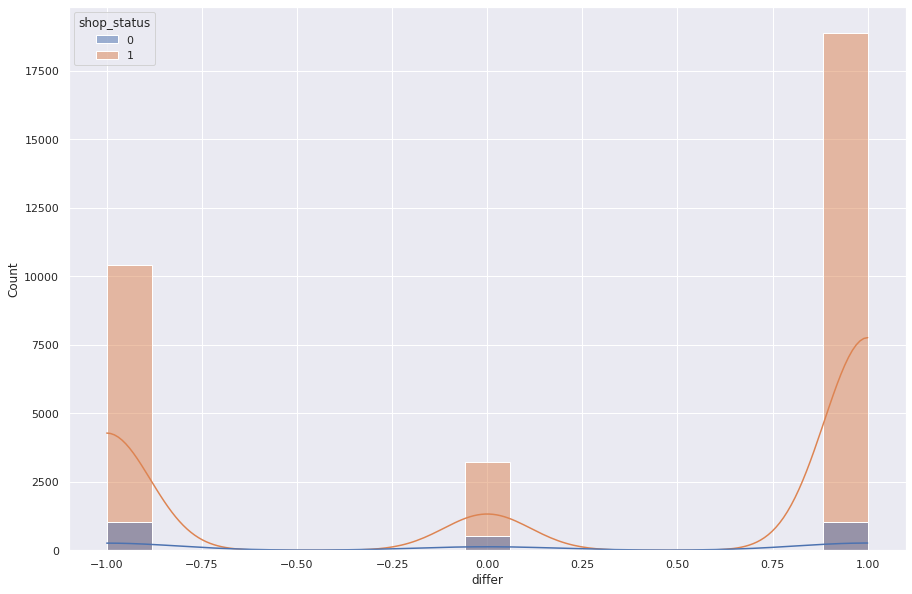

In [53]:
sns.histplot(data=data, x="differ", hue="shop_status",kde=True)

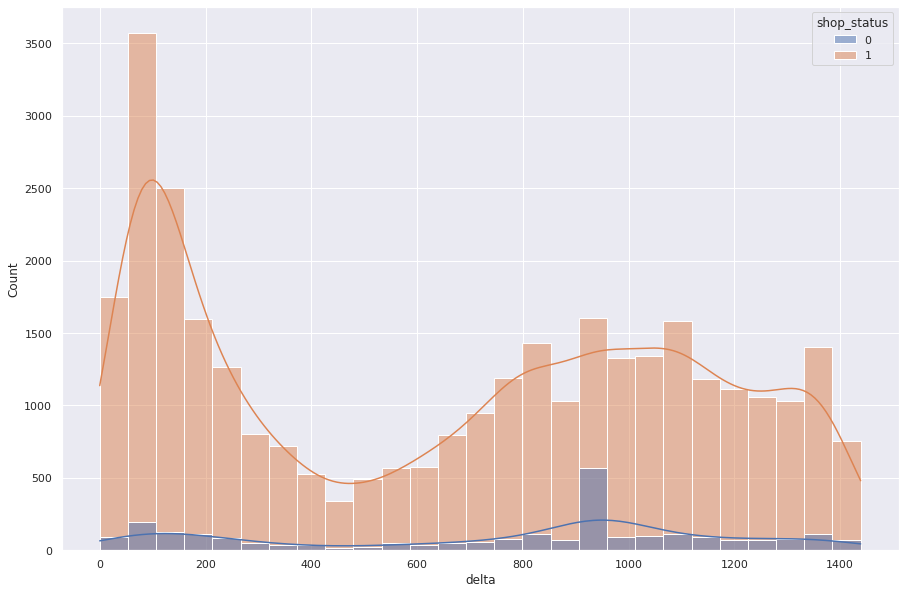

In [54]:
sns.histplot(data=data, x="delta", hue="shop_status",kde=True)

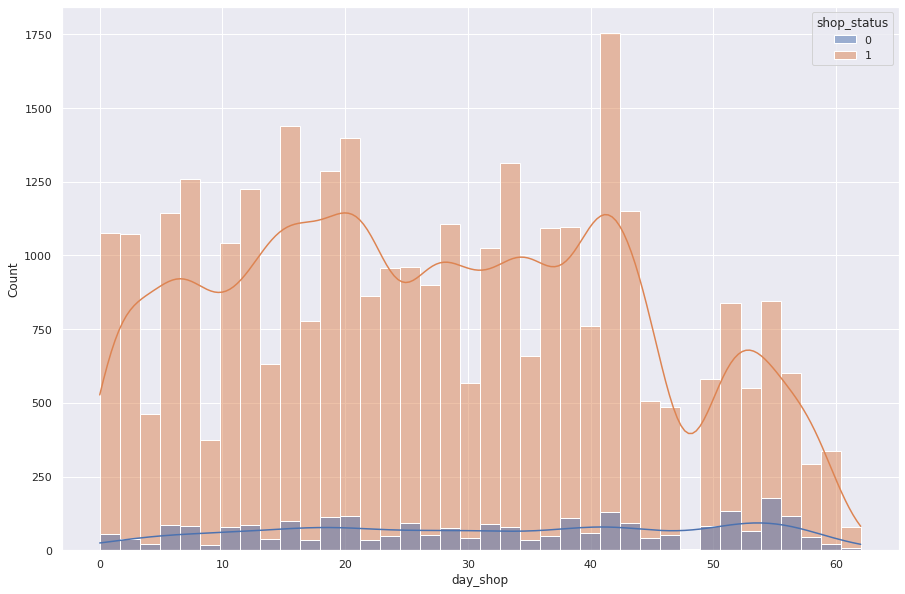

In [55]:
sns.histplot(data=data, x="day_shop", hue="shop_status",kde=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


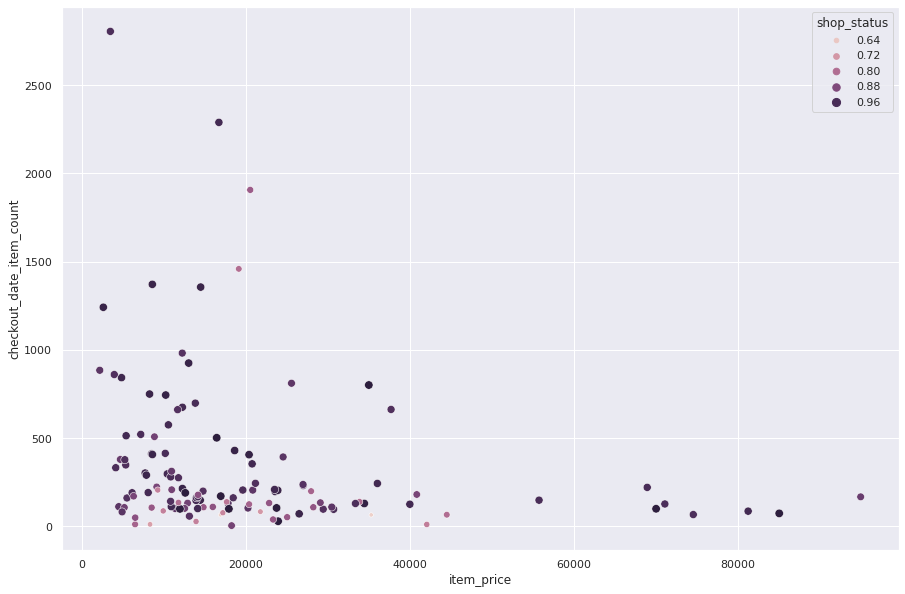

In [56]:
sns.scatterplot(data.groupby('item_category').mean().item_price,data.groupby('item_category').mean().checkout_date_item_count,
                hue=data.groupby('item_category').mean().shop_status,
                size=data.groupby('item_category').mean().shop_status)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


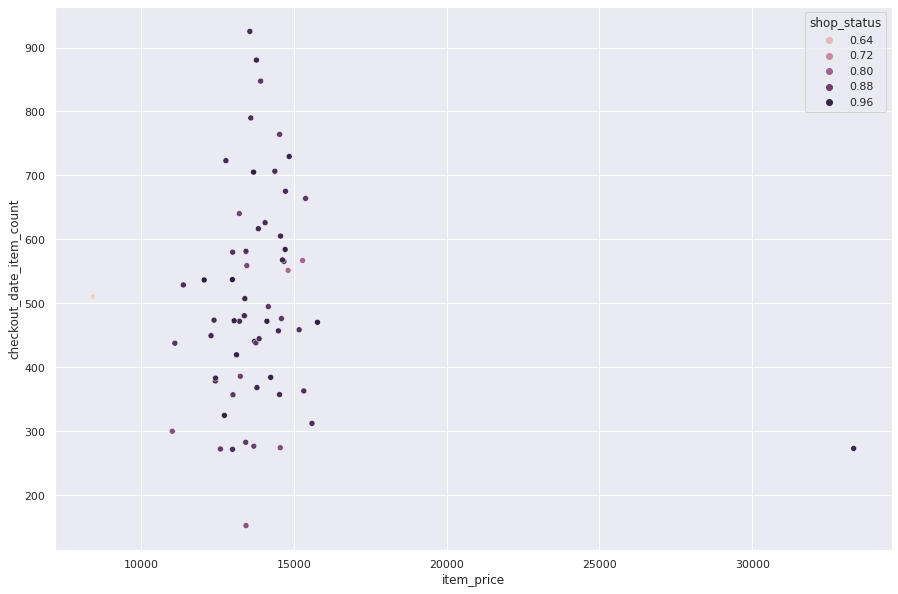

In [91]:
sns.scatterplot(data.groupby('day_shop').mean().item_price,data.groupby('day_shop').mean().checkout_date_item_count,
                hue=data.groupby('day_shop').mean().shop_status)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


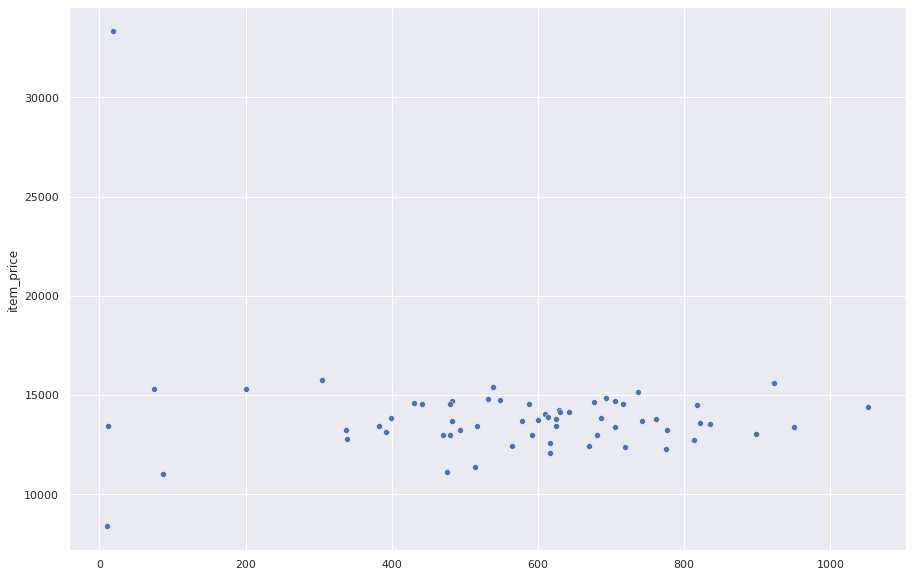

In [90]:
#count of order by price 
sns.scatterplot(data.groupby('day_shop').size(),data.groupby('day_shop').item_price.mean())

# **predict task1-b**

In [ ]:
data.keys()

Index(['item_id', 'checkout_date', 'checkout_date_item_count', 'shop_date',
       'shop_date_item_count', 'item_price', 'item_category', 'shop_status',
       'error', 'delta', 'differ'],
      dtype='object')

In [ ]:
model_data=data[['checkout_date_item_count', 'delta', 'shop_date_item_count',
       'item_price', 'item_category', 'shop_status']]

In [ ]:
#our data is imbalanced so first of all we must balanced with over sampeling on the class that is low in size 
#rpeat data for 
newdf = pd.DataFrame(np.repeat(model_data[model_data.shop_status==0].values, 12, axis=0), columns=model_data[model_data.shop_status==2].columns)

balance_dataset=pd.concat([newdf,model_data],ignore_index=True)

balance_dataset = shuffle(balance_dataset)

In [ ]:
balance_dataset

,checkout_date_item_count,delta,shop_date_item_count,item_price,item_category,shop_status
32032,31.0,108.0,27.0,24500.000000,2.0,1.0
64340,57.0,138.0,55.0,25050.242424,152.0,1.0
33313,70.0,122.0,70.0,46000.000000,58.0,1.0
57752,25.0,289.0,23.0,4800.000000,2.0,1.0
26954,177.0,1197.0,176.0,11000.000000,128.0,0.0
...,...,...,...,...,...,...
6652,44.0,1176.0,68.0,9950.722892,44.0,0.0
53807,131.0,1089.0,44.0,19160.888118,69.0,1.0
18943,25.0,1414.0,21.0,13951.219512,45.0,0.0
41853,42.0,1430.0,296.0,23500.000000,2.0,1.0


In [ ]:
#in this section we split data to test and train 
X_train, X_test, y_train, y_test = train_test_split(balance_dataset[['checkout_date_item_count','delta','shop_date_item_count', 'item_price', 'item_category']]
                                                    , balance_dataset['shop_status'], test_size=0.1, random_state=42)

In [ ]:
#then normlize in for machine learning model 
transformer = Normalizer().fit(X_train)
X_train=transformer.transform(X_train)
y_train=np.array(y_train)
X_test=transformer.transform(X_test)
y_test=np.array(y_test)

#fit a pca model on train data and reduce the dimention on to for visualization 
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X_train)
reduced_train=pca.transform(X_train)
reduced_test=pca.transform(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


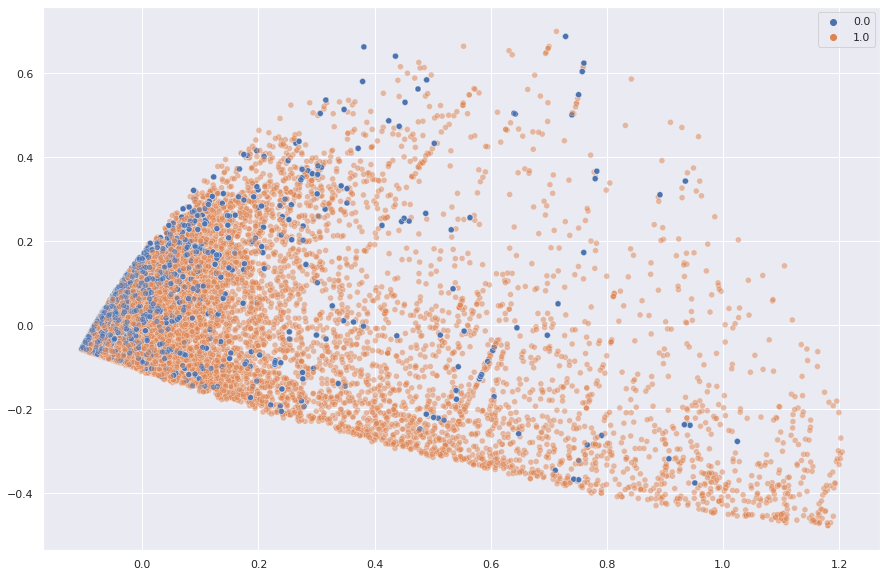

In [ ]:
#visualize train data 
sns.scatterplot(reduced_train[:,0],reduced_train[:,1], hue=y_train,alpha=0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


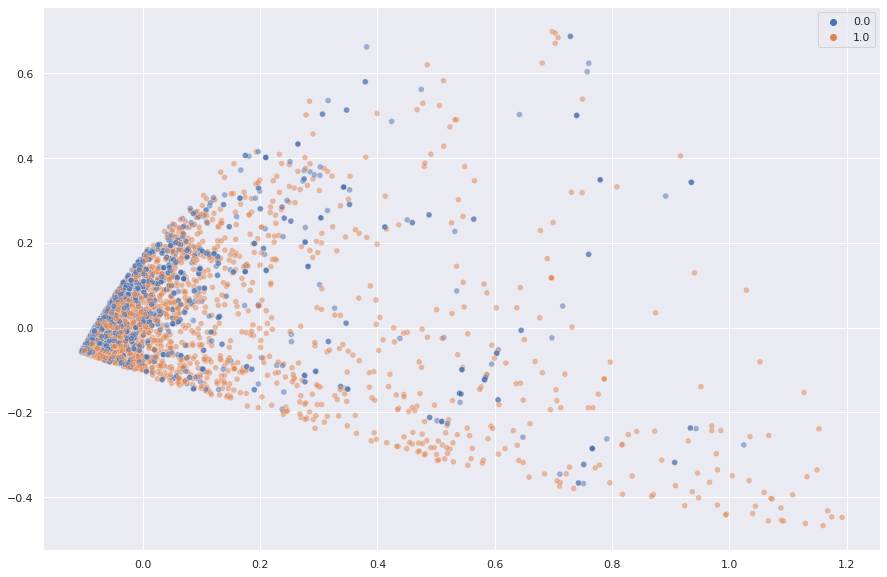

In [ ]:
#visualize the test data 
sns.scatterplot(reduced_test[:,0],reduced_test[:,1], hue=y_test,alpha=0.5)

0.580581938790894


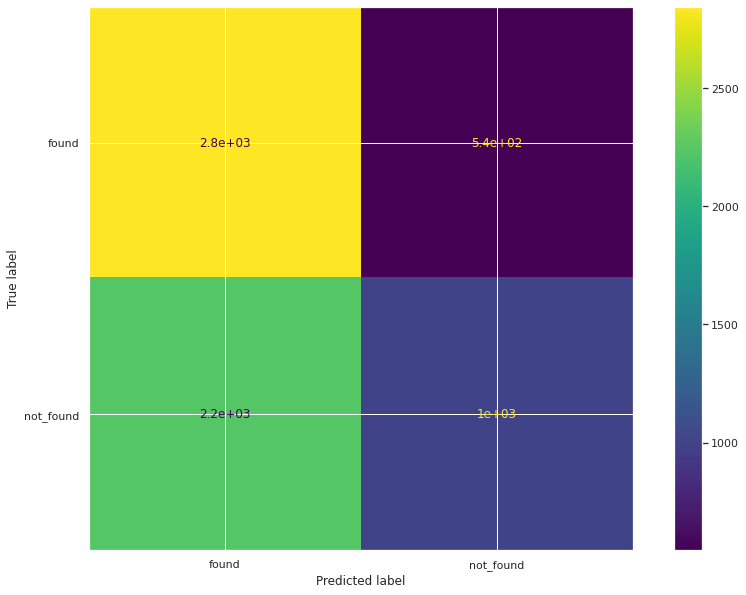

In [ ]:
#fite a logisticregression on data 
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))

metrics.plot_confusion_matrix(clf,X_test,y_test,display_labels=np.array(['found','not_found']))

0.5917382783054425


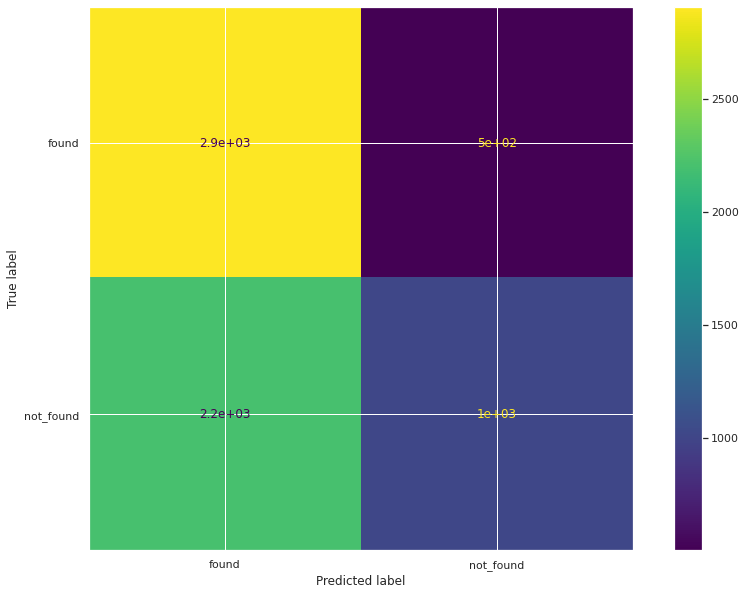

In [ ]:
#fit kenrnel svm with poly kernel 
clf = svm.SVC(kernel='poly', gamma=2).fit(X_train, y_train)
print(clf.score(X_test, y_test))

metrics.plot_confusion_matrix(clf,X_test,y_test,display_labels=np.array(['found','not_found']))

0.5903814262023217


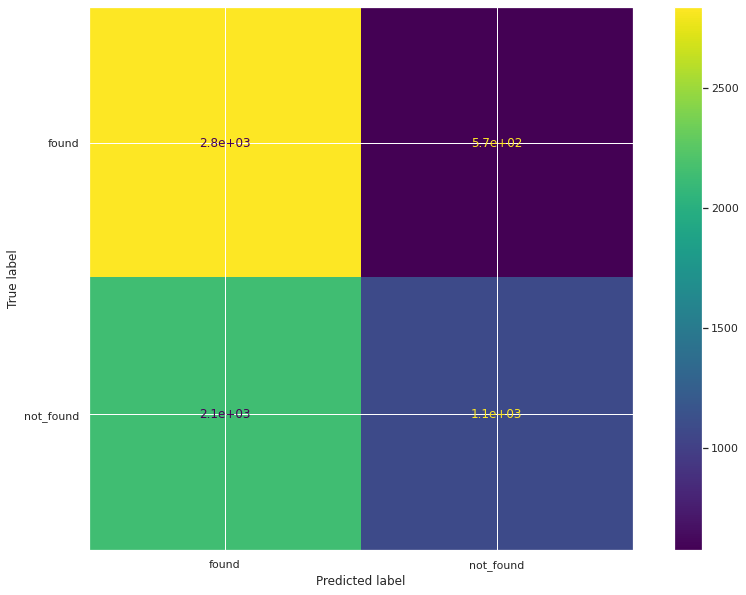

In [ ]:
#svm with rbf kernel
clf = svm.SVC(kernel='rbf', gamma=2).fit(X_train, y_train)
print(clf.score(X_test, y_test))

metrics.plot_confusion_matrix(clf,X_test,y_test,display_labels=np.array(['found','not_found']))

0.9810040705563093


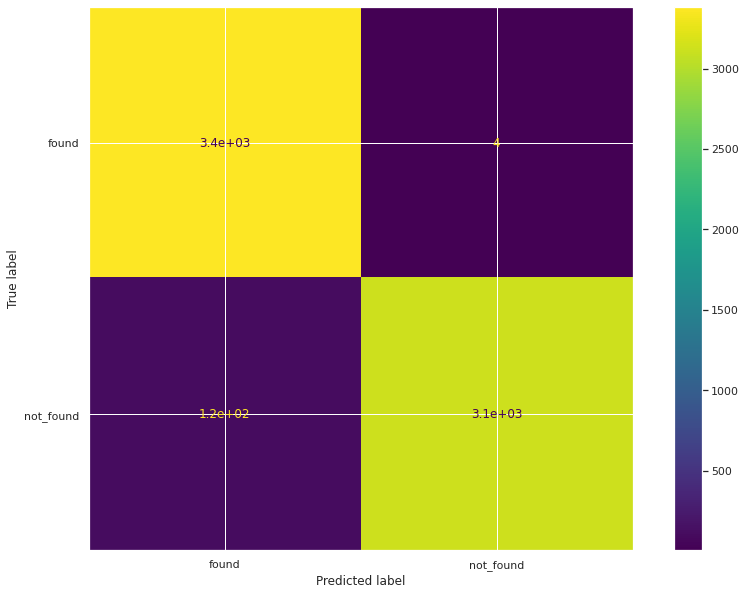

In [ ]:
#fit random foresst on data 
clf = RandomForestClassifier(max_depth=100, random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))

metrics.plot_confusion_matrix(clf,X_test,y_test,display_labels=np.array(['found','not_found']))

In [ ]:
# searching for best perceptron with 2 hiden layer, architecture 
I=range(10,20)
J=range(10,20)
ACC=np.zeros((10,10))
for i in I:
    for j in J:        
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(5,)),

            tf.keras.layers.Dense(i, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(j, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=15,batch_size=128)
        loss,acc=model.evaluate(X_test,y_test)
        ACC[i-10,j-10]=acc

np.max(ACC)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(5,)),

    tf.keras.layers.Dense(7, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100,batch_size=128)
loss,acc=model.evaluate(X_test,y_test)